In [109]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [110]:
# Configurar MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("toyota_project")

<Experiment: artifact_location='mlflow-artifacts:/761825226421448019', creation_time=1747620556720, experiment_id='761825226421448019', last_update_time=1747620556720, lifecycle_stage='active', name='toyota_project', tags={}>

In [111]:
# Cargar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/dodobeatle/dataeng-datos/refs/heads/main/ToyotaCorolla.csv",
    encoding="utf8",
    engine="python"
)

In [112]:
# =========================
# 1. EXPLORACIÓN DE DATOS
# =========================

features_selected = ["Price", "Age_08_04", "KM", "cc", "Doors", "Weight","Quarterly_Tax","Airco","CD_Player",]
df_selected = df[features_selected].copy()

# 👉 Filtro por sentido común / dominio
df_selected = df_selected[
    (df_selected["Price"] > 1000) & (df_selected["Price"] < 15000) &
    (df_selected["Age_08_04"] > 12) & (df_selected["Age_08_04"] < 100) &
    (df_selected["KM"] > 0) & (df_selected["KM"] < 160000) &
    (df_selected["cc"] > 600) & (df_selected["cc"] < 2500) &
    (df_selected["Weight"] > 800) & (df_selected["Weight"] < 1200) &
    (df_selected["Doors"].isin([3, 4, 5])) &
    (df_selected["Quarterly_Tax"] > 30) & (df_selected["Quarterly_Tax"] < 120)

]


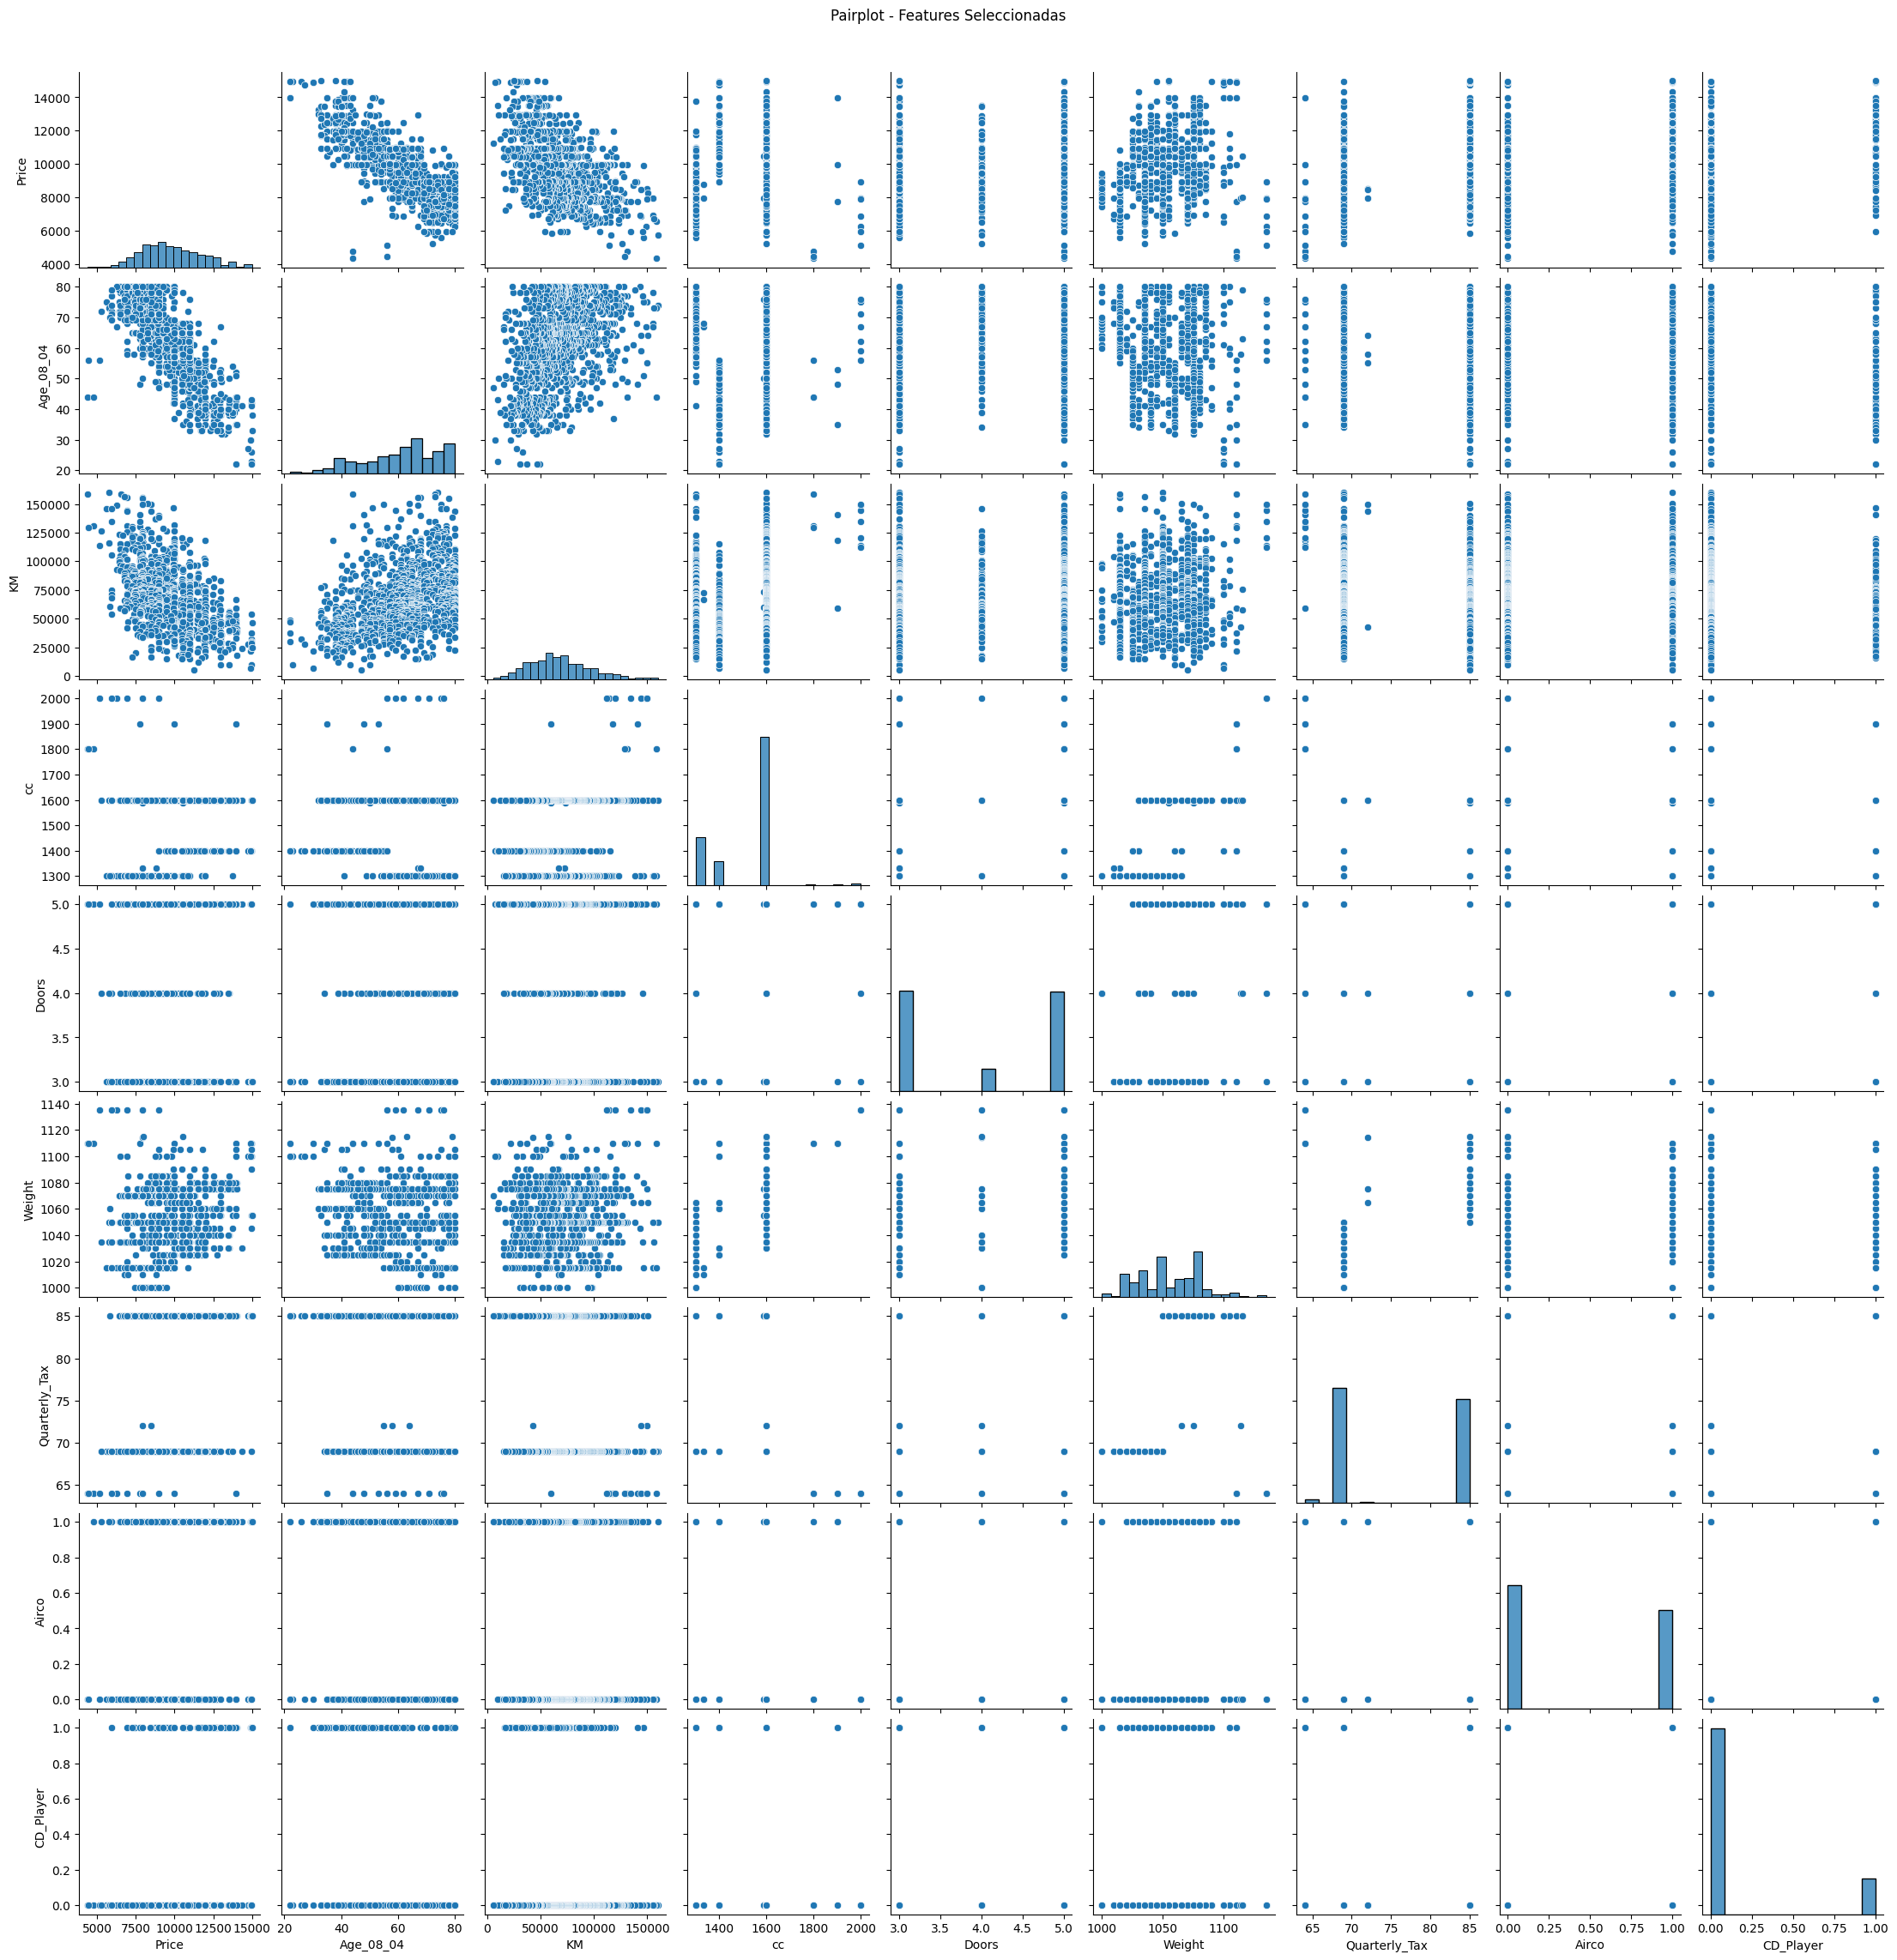

In [113]:
# Pairplot
sns.pairplot(data=df_selected.select_dtypes(include=np.number))
plt.suptitle("Pairplot - Features Seleccionadas", y=1.02)
plt.show()

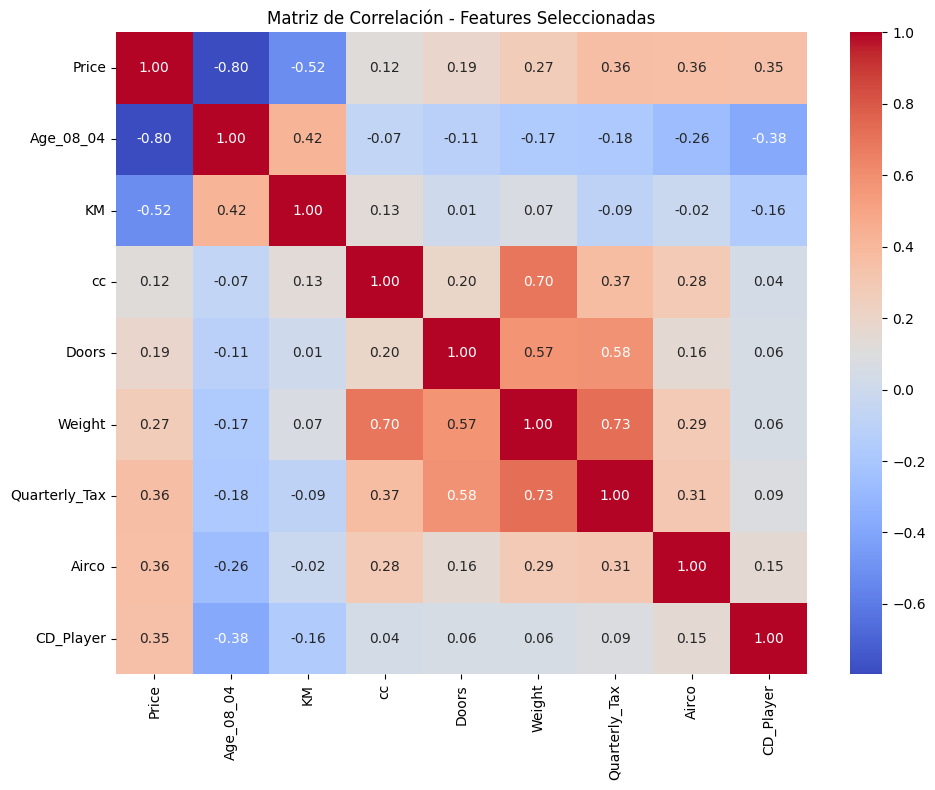

In [114]:
# Correlación (Pearson)
corr_matrix = df_selected.select_dtypes(include=np.number).corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación - Features Seleccionadas')
plt.tight_layout()
plt.show()

In [115]:
# Función para detectar outliers
def detect_outliers(df):
    import numpy as np
    cols = df.select_dtypes(include=np.number).columns
    outliers = pd.DataFrame(columns=['Feature', 'Number of Outliers'])
    for column in cols:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr
        n_outliers = df[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]
        outliers = pd.concat(
            [outliers, pd.DataFrame({'Feature': [column], 'Number of Outliers': [n_outliers]})],
            ignore_index=True
        )
    return outliers

outliers_df = detect_outliers(df_selected)
print(outliers_df)

         Feature Number of Outliers
0          Price                  0
1      Age_08_04                  0
2             KM                 18
3             cc                  7
4          Doors                  0
5         Weight                  0
6  Quarterly_Tax                  0
7          Airco                  0
8      CD_Player                172


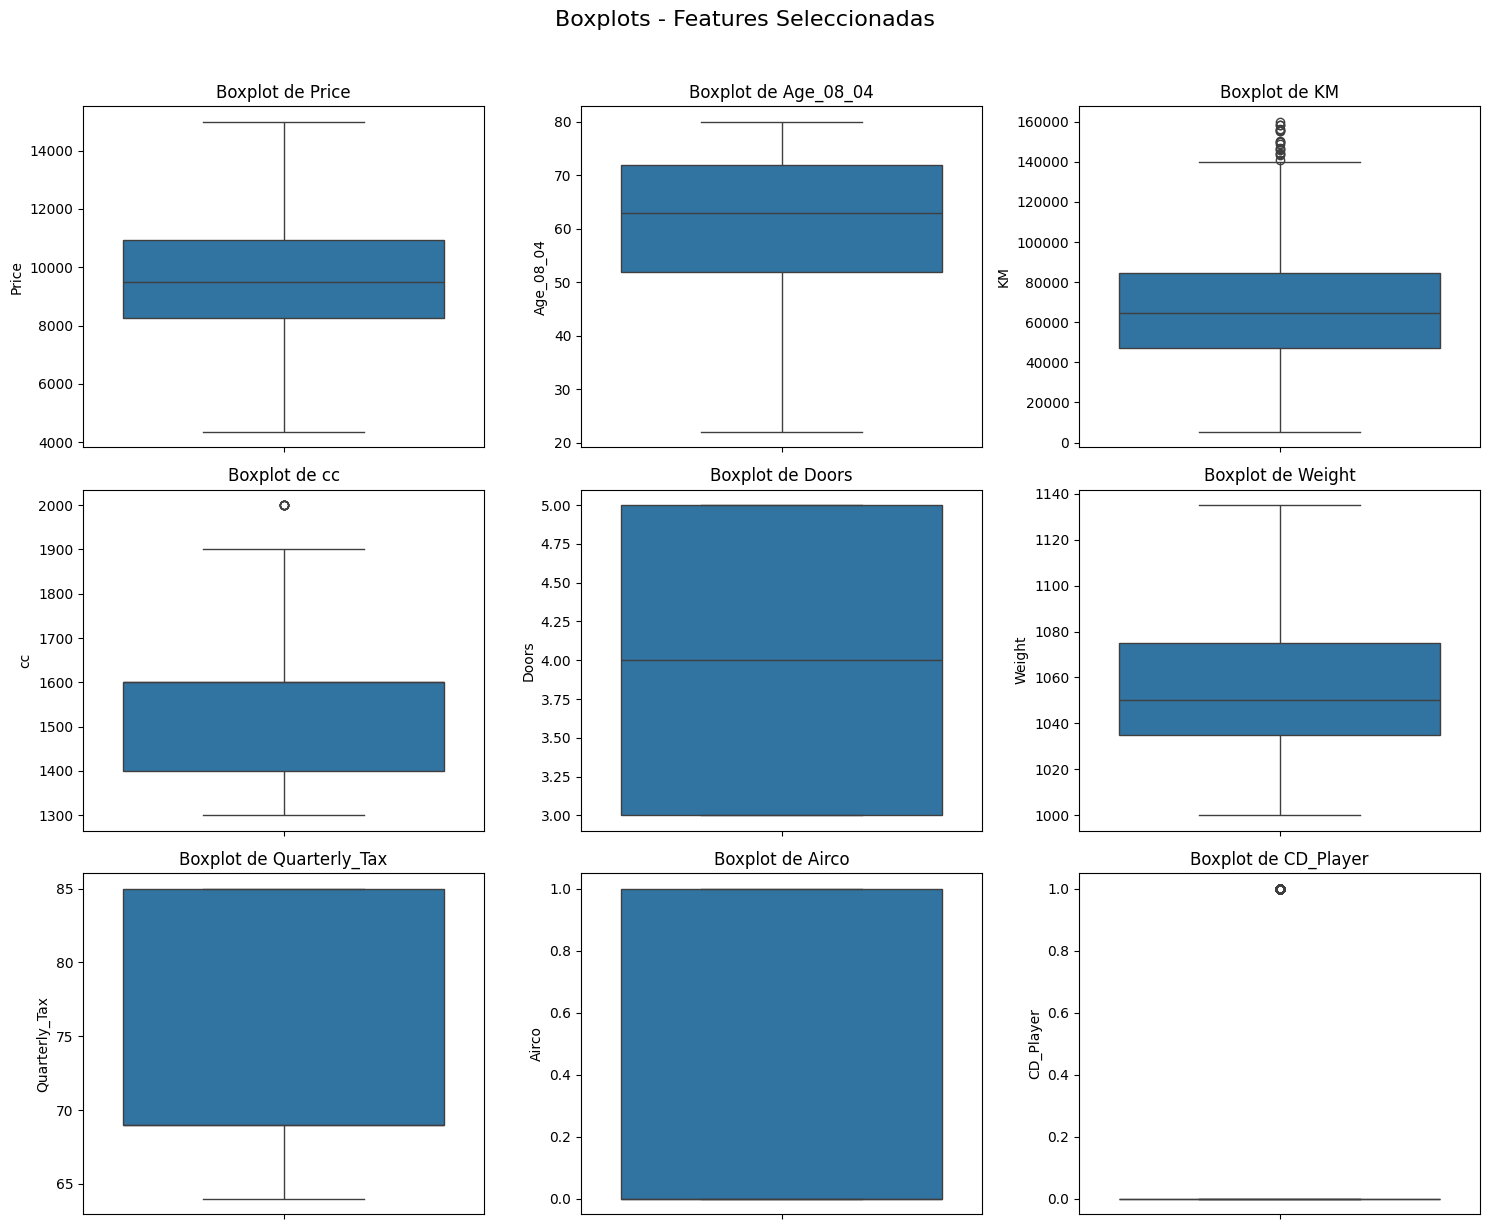

In [116]:
# Boxplots múltiples
import math

num_cols = df_selected.select_dtypes(include=np.number).columns.tolist()
n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, column in enumerate(num_cols):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(y=df_selected[column])
    plt.title(f'Boxplot de {column}')
    plt.tight_layout()

plt.suptitle('Boxplots - Features Seleccionadas', fontsize=16, y=1.02)
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.tight_layout()
plt.show()

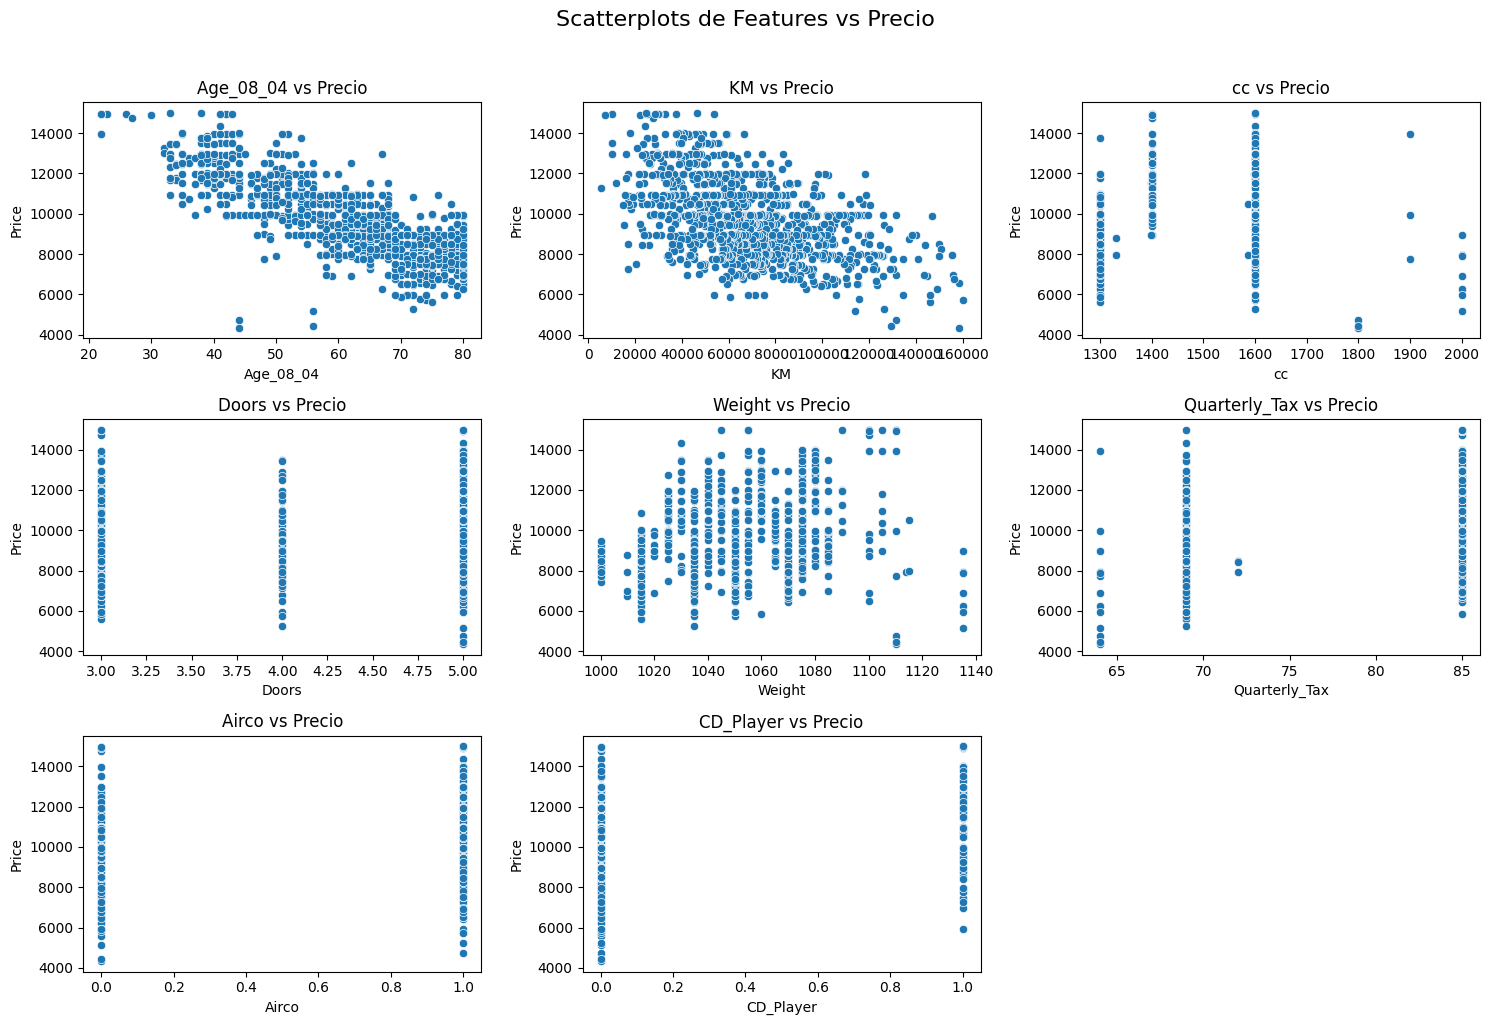

In [117]:

# Scatterplots
plt.figure(figsize=(15, 10))
for i, column in enumerate([f for f in features_selected if f != "Price"]):
    plt.subplot(3, 3, i + 1)  # 3x3 porque tenés 8 features numéricas
    sns.scatterplot(x=df_selected[column], y=df_selected["Price"])
    plt.title(f'{column} vs Precio')
    plt.tight_layout()

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.suptitle('Scatterplots de Features vs Precio', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [118]:
# =========================
# 2. PREPROCESAMIENTO
# =========================

# Separar variables
X = df.drop("Price", axis=1)
y = df["Price"]

X = df[features_selected[1:]]  # Excluye 'Price'
y = df["Price"]



# Preprocesamiento
X = pd.get_dummies(X, drop_first=True)           # One-hot encoding
X = X.apply(pd.to_numeric, errors='coerce')      # Forzar datos a numérico
y = pd.to_numeric(y, errors='coerce')            # Lo mismo para el target

# Combinar X e y para eliminar filas con NaNs
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop("Price", axis=1)
y = combined["Price"]

# Convertir a float y agregar constante para OLS
X = X.astype(float)
#y = y.astype(float)
X = sm.add_constant(X)

print(X.head())

   const  Age_08_04       KM      cc  Doors  Weight  Quarterly_Tax  Airco  \
0    1.0       23.0  46986.0  2000.0    3.0  1165.0          210.0    0.0   
1    1.0       23.0  72937.0  2000.0    3.0  1165.0          210.0    1.0   
2    1.0       24.0  41711.0  2000.0    3.0  1165.0          210.0    0.0   
3    1.0       26.0  48000.0  2000.0    3.0  1165.0          210.0    0.0   
4    1.0       30.0  38500.0  2000.0    3.0  1170.0          210.0    1.0   

   CD_Player  
0        0.0  
1        1.0  
2        0.0  
3        0.0  
4        0.0  


In [119]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1
)

In [120]:
# Iniciar experimento
with mlflow.start_run(run_name="ols_model_run"):
    # Ajustar modelo
    model = sm.OLS(y_train, X_train)
    results = model.fit()

    print(results.summary())

    # Predicciones
    y_pred = results.predict(X_test)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2_score", r2)

    # Log de métricas del modelo statsmodels
    mlflow.log_metric("aic", results.aic)
    mlflow.log_metric("bic", results.bic)
    mlflow.log_metric("df_model", results.df_model)
    mlflow.log_metric("fvalue", results.fvalue)
    mlflow.log_metric("rsquared", results.rsquared)
    mlflow.log_metric("rsquared_adj", results.rsquared_adj)
    mlflow.log_metric("ssr", results.ssr)  # suma de residuos al cuadrado

    # Crear carpeta si no existe
    os.makedirs("mlartifacts", exist_ok=True)

    # Guardar resumen como archivo .txt
    summary_path = os.path.join("mlartifacts", "ols_summary.txt")
    with open(summary_path, "w") as f:
        f.write(results.summary().as_text())
    mlflow.log_artifact(summary_path)

    # Guardar modelo con joblib
    model_path = os.path.join("mlartifacts", "ols_model.pkl")
    joblib.dump(results, model_path)
    mlflow.log_artifact(model_path)

    # Guardar nombres de features
    features_path = os.path.join("mlartifacts", "features.txt")
    with open(features_path, "w") as f:
        f.write("\n".join(X.columns))
    mlflow.log_artifact(features_path)

print("Modelo OLS registrado con MLflow.")

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     602.8
Date:                Tue, 20 May 2025   Prob (F-statistic):               0.00
Time:                        13:09:48   Log-Likelihood:                -7481.0
No. Observations:                 861   AIC:                         1.498e+04
Df Residuals:                     852   BIC:                         1.502e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -130.3493   1336.795     -0.098